In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [202]:
#loading the first dataset in 

url = 'https://github.com/tmartabano/Project-for-Data-Munging/raw/main/2000-2019.csv'
df1 = pd.read_csv(url)
df1.head()
#standardizing some of the measures 
df1['tempo'] = df1['tempo'].round(0)
df1['main_genre'] = df1['genre'].str.split(',').str[0]
df1['year'] = df1['year'].astype(float)

df1.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,main_genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000.0,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.0,pop,pop
1,blink-182,All The Small Things,167066,False,1999.0,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,149.0,"rock, pop",rock
2,Faith Hill,Breathe,250546,False,1999.0,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,137.0,"pop, country",pop
3,Bon Jovi,It's My Life,224493,False,2000.0,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,120.0,"rock, metal",rock
4,*NSYNC,Bye Bye Bye,200560,False,2000.0,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,173.0,pop,pop


In [244]:
#loading in second dataset
url = 'https://raw.githubusercontent.com/tmartabano/Project-for-Data-Munging/main/top_10000_1960-now.csv'
df2 = pd.read_csv(url)

#standardizing some measures 
df2['Tempo'] = df2['Tempo'].round(0)
df2['year'] = df2['Album Release Date'].str[-2:].astype(float)

#separating the dates from < 2000 and after > 2000
df2.loc[df2['year'] < 50, 'year'] += 2000
df2.loc[df2['year'] < 100, 'year'] += 1900
df2['year']
df2 = df2.sort_values(by='year', ascending=False)
df2



,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album Release Date,Album Image URL,...,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Album Genres,Label,Copyrights,year
9998,spotify:track:3iKuIfvoU50eww6EVzNqHo,Padam Padam,spotify:artist:4RVnAU35WRWra6OZ3CbbMA,Kylie Minogue,spotify:album:0OHc8STurn45gpk3dyIiw5,Padam Padam,spotify:artist:4RVnAU35WRWra6OZ3CbbMA,Kylie Minogue,5/19/23,https://i.scdn.co/image/ab67616d0000b2730536a8...,...,0.2140,0.001160,0.1030,0.711,128.0,4.0,NaN,Liberator Music,C 2023 Kylie Minogue/Darenote under exclusive ...,2023.0
9991,spotify:track:3AjSfp5FDvwtMU9XBsbS8j,Push Up - Main Edit,spotify:artist:2gW0M5fn2r7Lo4Hn1r8HZ5,Creeds,spotify:album:3v5BP6gPT1nNU9rjs57fF0,Push Up (Main Edit),spotify:artist:2gW0M5fn2r7Lo4Hn1r8HZ5,Creeds,3/31/23,https://i.scdn.co/image/ab67616d0000b273b1f8e7...,...,0.2090,0.836000,0.0582,0.187,75.0,4.0,NaN,Columbia/B1 Recordings,"P (P) 2023 Rave Alert Records, under exclusive...",2023.0
2428,spotify:track:3k79jB4aGmMDUQzEwa46Rz,vampire,spotify:artist:1McMsnEElThX1knmY4oliG,Olivia Rodrigo,spotify:album:5kqfR7EuGbyp8x27Pr1kY9,vampire,spotify:artist:1McMsnEElThX1knmY4oliG,Olivia Rodrigo,6/30/23,https://i.scdn.co/image/ab67616d0000b2731e5e75...,...,0.1690,0.000000,0.3110,0.322,138.0,4.0,NaN,Olivia Rodrigo PS,"C © 2023 Olivia Rodrigo, under exclusive licen...",2023.0
9935,spotify:track:6UbNrW8X1v4oOR29vzSVqX,One Day At A Time,"spotify:artist:2mF9PcfpN8vxRtCfra8hz1, spotify...","Thierry Von Der Warth, Jay Mason",spotify:album:5qrQjiR5PsDykstHLRAK23,One Day At A Time,"spotify:artist:2mF9PcfpN8vxRtCfra8hz1, spotify...","Thierry Von Der Warth, Jay Mason",3/3/23,https://i.scdn.co/image/ab67616d0000b2734fe2e6...,...,0.2240,0.000135,0.1170,0.526,122.0,4.0,NaN,Paraiso,"C 2023 Thierry Von Der Warth & Jay Mason, P 20...",2023.0
7789,spotify:track:5eTaQYBE1yrActixMAeLcZ,Miracle (with Ellie Goulding),"spotify:artist:7CajNmpbOovFoOoasH2HaY, spotify...","Calvin Harris, Ellie Goulding",spotify:album:22UyygZceCIfoE0RhENgKx,Miracle (with Ellie Goulding),"spotify:artist:7CajNmpbOovFoOoasH2HaY, spotify...","Calvin Harris, Ellie Goulding",3/10/23,https://i.scdn.co/image/ab67616d0000b273c58e22...,...,0.0378,0.044600,0.0808,0.306,143.0,4.0,NaN,Columbia,P (P) 2023 Sony Music Entertainment UK Limited,2023.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2356,spotify:track:33aYzW5ToRjiFOzkubeJ8H,Rave On,"spotify:artist:3wYyutjgII8LJVVOLrGI0D, spotify...","Buddy Holly, The Crickets",spotify:album:4Qy0SOU9Jg7Td10K68SanP,Buddy Holly,spotify:artist:3wYyutjgII8LJVVOLrGI0D,Buddy Holly,1958,https://i.scdn.co/image/ab67616d0000b27358816b...,...,0.6110,0.000007,0.4170,0.961,160.0,4.0,NaN,Geffen,"C © 1958 UMG Recordings Inc., P This Compilati...",1958.0
4106,spotify:track:6xNwKNYZcvgV3XTIwsgNio,Heartbreak Hotel,spotify:artist:43ZHCT0cAZBISjO8DG9PnE,Elvis Presley,spotify:album:0C3t1htEDTFKcg7F2rNbek,Elvis' Golden Records,spotify:artist:43ZHCT0cAZBISjO8DG9PnE,Elvis Presley,3/21/58,https://i.scdn.co/image/ab67616d0000b27320ee3e...,...,0.8400,0.000002,0.1070,0.717,94.0,4.0,NaN,RCA Records Label,P (P) 1958 Sony Music Entertainment,1958.0
7007,spotify:track:47gmoUrZV3w20JAnQOZMcO,Blue Suede Shoes,spotify:artist:43ZHCT0cAZBISjO8DG9PnE,Elvis Presley,spotify:album:7GXP5OhYyPVLmcVfO9Iqin,Elvis Presley,spotify:artist:43ZHCT0cAZBISjO8DG9PnE,Elvis Presley,3/23/56,https://i.scdn.co/image/ab67616d0000b273f45cec...,...,0.6540,0.000002,0.1380,0.962,95.0,4.0,NaN,RCA Victor,P (P) 1956 Sony Music Entertainment,1956.0
2714,spotify:local:The+Beatles:1962-1966:You%27ve+G...,You've Got To Hide Your Love Away,NaN,The Beatles,NaN,1962-1966,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [253]:
#sett of conditions to get the genre into usable data
conditions = [
    df2['Artist Genres'].str.contains('pop', case=False, na=False),
    df2['Artist Genres'].str.contains('rock', case=False, na=False),
    df2['Artist Genres'].str.contains('hip hop', case=False, na=False),
    df2['Artist Genres'].str.contains('country', case=False, na=False),
     df2['Artist Genres'].str.contains('soul', case=False, na=False)
]

#possible genres if not its other 
categories = ['pop', 'rock', 'hip hop', 'country','soul']

# Apply the conditions and assign categories
df2['Genre Category'] = np.select(conditions, categories, default='Other')
df2.head()

,Track URI,Track Name,Artist URI(s),Artist Name(s),Album URI,Album Name,Album Artist URI(s),Album Artist Name(s),Album Release Date,Album Image URL,...,Instrumentalness,Liveness,Valence,Tempo,Time Signature,Album Genres,Label,Copyrights,year,Genre Category
9998,spotify:track:3iKuIfvoU50eww6EVzNqHo,Padam Padam,spotify:artist:4RVnAU35WRWra6OZ3CbbMA,Kylie Minogue,spotify:album:0OHc8STurn45gpk3dyIiw5,Padam Padam,spotify:artist:4RVnAU35WRWra6OZ3CbbMA,Kylie Minogue,5/19/23,https://i.scdn.co/image/ab67616d0000b2730536a8...,...,0.001160,0.1030,0.711,128.0,4.0,NaN,Liberator Music,C 2023 Kylie Minogue/Darenote under exclusive ...,2023.0,pop
9991,spotify:track:3AjSfp5FDvwtMU9XBsbS8j,Push Up - Main Edit,spotify:artist:2gW0M5fn2r7Lo4Hn1r8HZ5,Creeds,spotify:album:3v5BP6gPT1nNU9rjs57fF0,Push Up (Main Edit),spotify:artist:2gW0M5fn2r7Lo4Hn1r8HZ5,Creeds,3/31/23,https://i.scdn.co/image/ab67616d0000b273b1f8e7...,...,0.836000,0.0582,0.187,75.0,4.0,NaN,Columbia/B1 Recordings,"P (P) 2023 Rave Alert Records, under exclusive...",2023.0,Other
2428,spotify:track:3k79jB4aGmMDUQzEwa46Rz,vampire,spotify:artist:1McMsnEElThX1knmY4oliG,Olivia Rodrigo,spotify:album:5kqfR7EuGbyp8x27Pr1kY9,vampire,spotify:artist:1McMsnEElThX1knmY4oliG,Olivia Rodrigo,6/30/23,https://i.scdn.co/image/ab67616d0000b2731e5e75...,...,0.000000,0.3110,0.322,138.0,4.0,NaN,Olivia Rodrigo PS,"C © 2023 Olivia Rodrigo, under exclusive licen...",2023.0,pop
9935,spotify:track:6UbNrW8X1v4oOR29vzSVqX,One Day At A Time,"spotify:artist:2mF9PcfpN8vxRtCfra8hz1, spotify...","Thierry Von Der Warth, Jay Mason",spotify:album:5qrQjiR5PsDykstHLRAK23,One Day At A Time,"spotify:artist:2mF9PcfpN8vxRtCfra8hz1, spotify...","Thierry Von Der Warth, Jay Mason",3/3/23,https://i.scdn.co/image/ab67616d0000b2734fe2e6...,...,0.000135,0.1170,0.526,122.0,4.0,NaN,Paraiso,"C 2023 Thierry Von Der Warth & Jay Mason, P 20...",2023.0,Other
7789,spotify:track:5eTaQYBE1yrActixMAeLcZ,Miracle (with Ellie Goulding),"spotify:artist:7CajNmpbOovFoOoasH2HaY, spotify...","Calvin Harris, Ellie Goulding",spotify:album:22UyygZceCIfoE0RhENgKx,Miracle (with Ellie Goulding),"spotify:artist:7CajNmpbOovFoOoasH2HaY, spotify...","Calvin Harris, Ellie Goulding",3/10/23,https://i.scdn.co/image/ab67616d0000b273c58e22...,...,0.044600,0.0808,0.306,143.0,4.0,NaN,Columbia,P (P) 2023 Sony Music Entertainment UK Limited,2023.0,pop


In [250]:
#loading in the third and final dataset 

url = 'https://raw.githubusercontent.com/tmartabano/Project-for-Data-Munging/main/30ksongs.csv'
df3 = pd.read_csv(url)

# standardizing the year into a usable format
df3['year'] = pd.to_datetime(df3['track_album_release_date'], errors='coerce').dt.year
#df3['year'] = df3['year'].astype(float)
#df3 = df3.sort_values(by='year', ascending=False)

good_df = df3[df3['year'] < 2025]
error_df = df3[df3['year'] > 2025]

error_df = error_df.copy()
error_df.loc[error_df['year'] > 2025, 'year'] -= 100
fix_df = error_df

df3_b = pd.concat([good_df, fix_df], ignore_index=True)
df3_b['year'] = df3_b['year'].astype(float)

In [251]:
#test code block
df4 = df3[['track_name', 'track_artist', 'playlist_genre']]
df4['track_name'].groupby(df4['playlist_genre']).count()

playlist_genre
edm      6043
latin    5153
pop      5507
r&b      5431
rap      5743
rock     4951
Name: track_name, dtype: int64

In [254]:
#formatting the data we want into new dataframes with uniform column names 

# For df1
df4 = df1[['song', 'artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'main_genre']]
df4.columns = ['song', 'artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'main_genre']
# For df2
df5 = df2[['Track Name', 'Artist Name(s)', 'year', 'Track Duration (ms)', 'Key', 'Loudness', 'Mode', 'Tempo', 'Genre Category']]
df5.columns = ['song', 'artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'main_genre']
# For df3
df6 = df3_b[['track_name', 'track_artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'playlist_genre']]
df6.columns = ['song', 'artist', 'year', 'duration_ms', 'key', 'loudness', 'mode', 'tempo', 'main_genre']

In [258]:
#start of new method 

df6 = df6.dropna()
df5 = df5.dropna()
df4 = df4.dropna()
missing_values = big_df.isnull().sum()
missing_values

song           0
artist         0
year           0
duration_ms    0
key            0
loudness       0
mode           0
tempo          0
main_genre     0
minutes        0
decade         0
dtype: int64

In [298]:
#joining the 3 dfs into 1 df and getting rid of missing values 
frames = [df4, df5, df6]
big_df = pd.concat(frames)
missing_values = big_df.isnull().sum()
missing_values
big_df.drop_duplicates(subset=['song'], inplace=True)


In [293]:
#code that fixes the issue with the year and creates decades column
condition = big_df['year'] > 2025
big_df.loc[condition, 'year'] -= 100
sorted_value_counts = big_df['year'].value_counts().sort_index(ascending=False)

big_df['decade'] = big_df['year'].astype(str).str[2:3] + '0s'
big_df.head(50)

,song,artist,year,duration_ms,key,loudness,mode,tempo,main_genre,decade
0,Oops!...I Did It Again,Britney Spears,2000.0,211160,1.0,-5.444,0.0,95.0,pop,00s
1,All The Small Things,blink-182,1999.0,167066,0.0,-4.918,1.0,149.0,rock,90s
2,Breathe,Faith Hill,1999.0,250546,7.0,-9.007,1.0,137.0,pop,90s
3,It's My Life,Bon Jovi,2000.0,224493,0.0,-4.063,0.0,120.0,rock,00s
4,Bye Bye Bye,*NSYNC,2000.0,200560,8.0,-4.806,0.0,173.0,pop,00s
5,Thong Song,Sisqo,1999.0,253733,2.0,-6.959,1.0,122.0,hip hop,90s
6,The Real Slim Shady,Eminem,2000.0,284200,5.0,-4.244,0.0,105.0,hip hop,00s
7,Rock DJ,Robbie Williams,2000.0,258560,7.0,-4.264,1.0,103.0,pop,00s
8,Say My Name,Destiny's Child,1999.0,271333,5.0,-3.525,0.0,138.0,pop,90s
9,Lady - Hear Me Tonight,Modjo,2001.0,307153,6.0,-5.627,1.0,126.0,Dance/Electronic,00s


In [310]:
#rounding tempo has it is measured by nearest whole number 
big_df['tempo'] = big_df['tempo'].round(0)
big_df['minutes'] = big_df['duration_ms'] / 60000
big_df['decade'] = big_df['year'].astype(str).str[2:3] + '0s'
big_df['decade']

0        00s
1        90s
2        90s
3        00s
4        00s
        ... 
32827    70s
32828    70s
32829    60s
32830    60s
32831    60s
Name: decade, Length: 29454, dtype: object

In [311]:
genre_counts = big_df['main_genre'].value_counts()

# Replace genres with count <= 10 with 'Other'
big_df['main_genre'] = big_df['main_genre'].apply(lambda x: 'Other' if genre_counts[x] <= 10 else x)
big_df['main_genre'] = big_df['main_genre'].replace('r&b', 'R&B')

In [312]:
#set is put into other genre because we have no clue what set() music is!!!
big_df['main_genre'] = big_df['main_genre'].replace('set()', 'Other')


In [313]:
#What genre has the most songs in our dataset?
Total_song_genre = big_df.groupby('main_genre')['song'].count().sort_values(ascending = False)
Total_song_genre

main_genre
pop                 7705
rock                4678
rap                 4546
edm                 3678
latin               3256
R&B                 3086
Other               1368
hip hop              842
soul                 205
country               53
Dance/Electronic      37
Name: song, dtype: int64

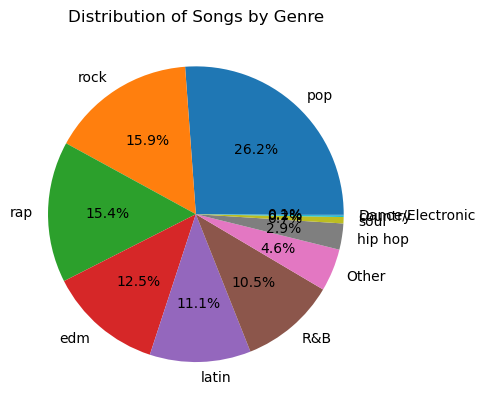

In [314]:
plt.pie(Total_song_genre, labels=Total_song_genre.index, autopct='%1.1f%%')
plt.title('Distribution of Songs by Genre')
plt.show()

In [220]:
#This data is for question 2 (duration)

In [315]:
avg_duration = big_df.groupby('main_genre')['duration_ms'].mean().sort_values(ascending = False)
avg_min = avg_duration / 60000
avg_min

main_genre
Dance/Electronic    4.042049
rock                4.000286
R&B                 3.968907
hip hop             3.885630
edm                 3.848132
pop                 3.685785
latin               3.647511
Other               3.606211
soul                3.570492
rap                 3.520967
country             3.362379
Name: duration_ms, dtype: float64

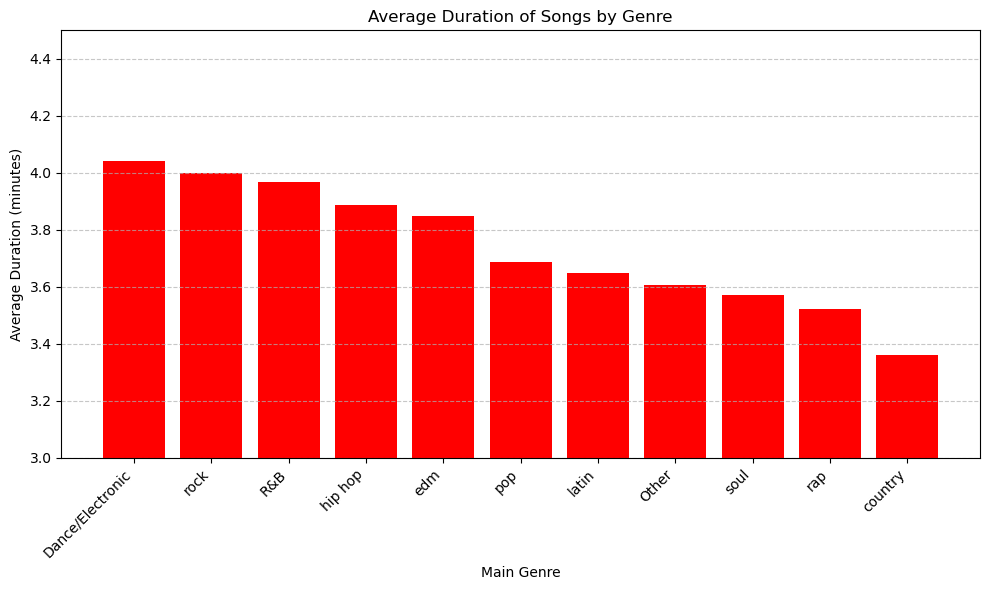

In [316]:
#chart 2 
plt.figure(figsize=(10, 6))
plt.bar(avg_min.index, avg_min.values, color= 'red')
plt.xlabel('Main Genre')
plt.ylabel('Average Duration (minutes)')
plt.title('Average Duration of Songs by Genre')
plt.xticks(rotation=45, ha='right')
plt.ylim(3.0, 4.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the bar graph
plt.tight_layout()
plt.show()

In [317]:
#On avgeage what genre has the fastest tempo 
avg_tempo = big_df.groupby('main_genre')['tempo'].mean().sort_values(ascending = False)
avg_tempo

main_genre
country             129.660377
edm                 126.247145
Dance/Electronic    124.891892
rock                124.412142
Other               121.578216
pop                 121.144841
rap                 120.619446
latin               119.000307
hip hop             117.884798
soul                117.248780
R&B                 113.890473
Name: tempo, dtype: float64

In [307]:
#years with the most songs in the dataset 
Total_song_year = big_df.groupby('year')['song'].count().sort_values(ascending = False)
Total_song_year

year
2019.0    6172
2018.0    2516
2017.0    1913
2016.0    1620
2015.0    1505
          ... 
1961.0       8
1958.0       7
1959.0       3
1957.0       2
1956.0       1
Name: song, Length: 68, dtype: int64

In [318]:
chart3 =  big_df[['main_genre','tempo', 'minutes']]
chart3

,main_genre,tempo,minutes
0,pop,95.0,3.519333
1,rock,149.0,2.784433
2,pop,137.0,4.175767
3,rock,120.0,3.741550
4,pop,173.0,3.342667
...,...,...,...
32827,R&B,106.0,4.855333
32828,R&B,127.0,5.011550
32829,R&B,100.0,2.847333
32830,R&B,76.0,2.703333


In [319]:
#comparison across genre 
genre_compare_df = big_df.groupby('main_genre')[['loudness', 'tempo', 'minutes']].mean()
#genre_compare_df.plot.scatter( 'loudness', 'tempo', s = genre_compare_df['minutes'] * 1000)
genre_compare_df

,loudness,tempo,minutes
main_genre,,,
Dance/Electronic,-5.968946,124.891892,4.042049
Other,-8.297442,121.578216,3.606211
R&B,-8.068679,113.890473,3.968907
country,-8.380755,129.660377,3.362379
edm,-5.553183,126.247145,3.848132
hip hop,-5.778588,117.884798,3.885630
latin,-6.541792,119.000307,3.647511
pop,-6.589017,121.144841,3.685785
rap,-7.170953,120.619446,3.520967


In [320]:
#mode count by genre 
mode_counts = big_df.groupby('main_genre')['mode'].value_counts()
mode_counts
#unsure if this is correct 

main_genre        mode
Dance/Electronic  1.0       21
                  0.0       16
Other             1.0      976
                  0.0      392
R&B               1.0     1606
                  0.0     1480
country           1.0       51
                  0.0        2
edm               1.0     1908
                  0.0     1770
hip hop           1.0      455
                  0.0      387
latin             1.0     1843
                  0.0     1413
pop               1.0     4879
                  0.0     2826
rap               1.0     2380
                  0.0     2166
rock              1.0     3345
                  0.0     1333
soul              1.0      153
                  0.0       52
Name: mode, dtype: int64

In [228]:
#who are the most popular singers in the dataset
top_10_artists = big_df['artist'].value_counts().head(10)
top_10_artists

Queen               167
Martin Garrix       166
The Chainsmokers    135
David Guetta        134
Drake               128
Calvin Harris       120
Ed Sheeran          118
Maroon 5            111
Rihanna             107
Don Omar            102
Name: artist, dtype: int64

In [229]:
#Data below is for tempo analysis

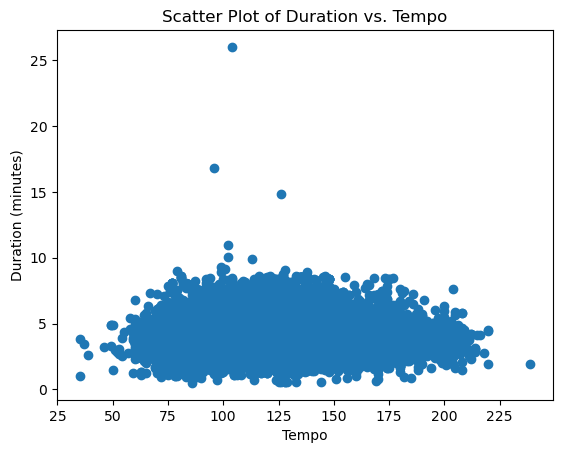

In [230]:
plt.scatter(big_df['tempo'], big_df['minutes'])
plt.xlabel('Tempo')
plt.ylabel('Duration (minutes)')
plt.title('Scatter Plot of Duration vs. Tempo')
plt.show()

In [231]:
#creating a pop df
pop_df = big_df[big_df['main_genre'] == 'pop']

In [232]:
#creating a rock df
rock_df = big_df[big_df['main_genre'] == 'rock']

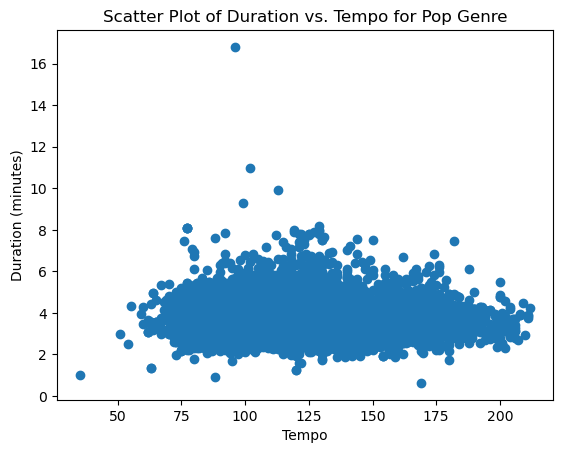

In [233]:
plt.scatter(pop_df['tempo'], pop_df['minutes'])
plt.xlabel('Tempo')
plt.ylabel('Duration (minutes)')
plt.title('Scatter Plot of Duration vs. Tempo for Pop Genre')
plt.show()

In [234]:
tempo_df_all = big_df[['main_genre', 'tempo']].copy()
# bin_edges = np.arange(0, 241, 4)
# tempo_df['tempo_bins'] = (pd.cut(tempo_df['tempo'], bins=bin_edges, labels=bin_edges[1:])).astype(str)
tempo_df = tempo_df_all[~tempo_df_all['main_genre'].isin(['Other', 'set()'])]
tempo_df = tempo_df.sort_values(by='tempo')
tempo_df

,main_genre,tempo
1204,pop,35.0
13764,rock,37.0
5629,rap,39.0
25793,R&B,46.0
21266,latin,49.0
...,...,...
1501,rock,218.0
18406,latin,220.0
27095,edm,220.0
28158,edm,220.0


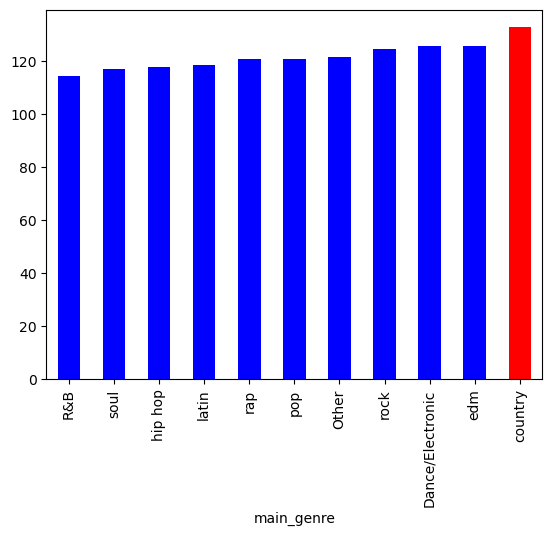

In [278]:
tempo_detail = tempo_detail.sort_values('tempo', ascending=True)
tempo_detail['tempo'].plot(kind='bar', color=['blue'] * (len(tempo_detail) - 1) + ['red'])
plt.show()

In [236]:
#tempo further analysis
tempo_detail = big_df.groupby('main_genre')[['tempo']].mean()
tempo_detail['tempo_stdev'] = big_df.groupby('main_genre')[['tempo']].std()
tempo_detail

,tempo,tempo_stdev
main_genre,,
Dance/Electronic,125.536585,18.926301
Other,121.707683,25.177212
R&B,114.211425,28.640234
country,132.779412,32.944026
edm,125.766507,15.321813
hip hop,117.616580,27.991258
latin,118.642221,29.163877
pop,120.875677,25.441450
rap,120.656451,31.644201


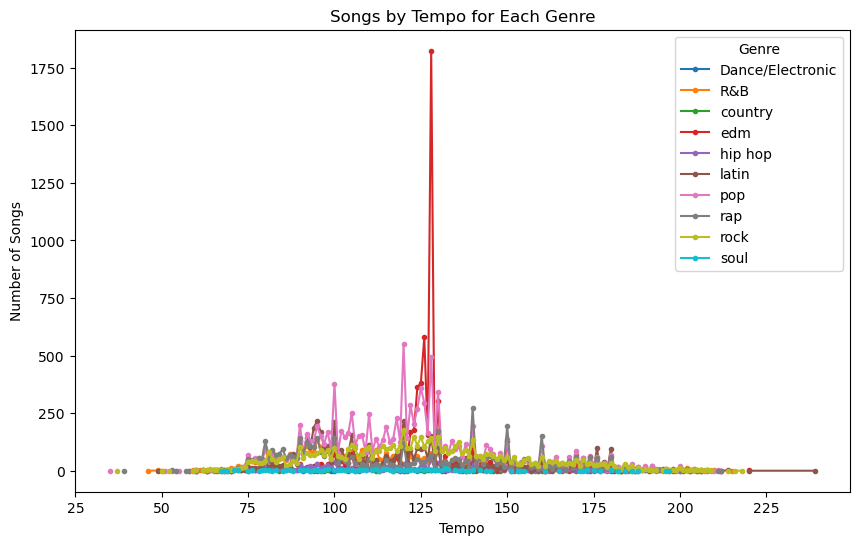

In [279]:
tempo_counts = tempo_df.groupby(['main_genre', 'tempo']).size().reset_index(name='count')

pivot_df = tempo_counts.pivot(index='tempo', columns='main_genre', values='count')

pivot_df.plot(kind='line', marker='.', figsize=(10, 6))
plt.title('Songs by Tempo for Each Genre')
plt.xlabel('Tempo')
plt.ylabel('Number of Songs')
plt.legend(title='Genre')
plt.show()

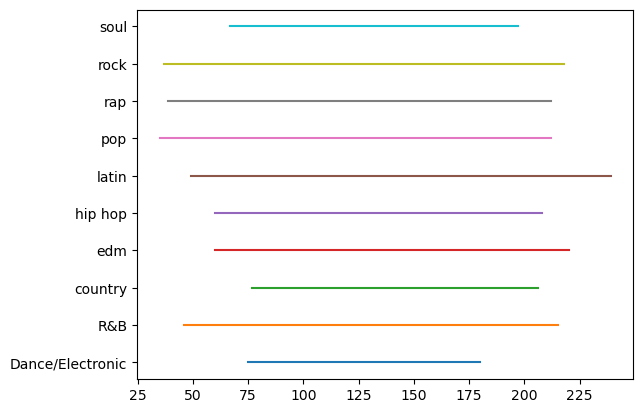

In [280]:
#figure out how to order by size 
import matplotlib.pyplot as plt
for genre, group in tempo_counts.groupby('main_genre'):
    plt.plot(group['tempo'], group['main_genre'], label=genre)

In [281]:
min_values = big_df.max()
min_values


song           하드캐리 Hard Carry
artist                    香取慎吾
year                    2023.0
duration_ms            1561133
key                       11.0
loudness                 2.769
mode                       1.0
tempo                    239.0
main_genre                soul
minutes              26.018883
decade                     90s
dtype: object

11653    False
14453    False
15278    False
12827    False
15379    False
         ...  
4381     False
2356     False
2827     False
13408    False
7007     False
Name: year, Length: 44822, dtype: bool

In [283]:
big_df = big_df.sort_values('year', ascending=False)

big_df.head(1000)



,song,artist,year,duration_ms,key,loudness,mode,tempo,main_genre,minutes,decade
1046,10:35,"Tiësto, Tate McRae",2023.0,172252,8.0,-5.733,1.0,120.0,pop,2.870867,20s
213,Flowers,Miley Cyrus,2023.0,200454,0.0,-4.325,1.0,118.0,pop,3.340900,20s
7355,Growin' Up and Gettin' Old,Luke Combs,2023.0,233666,2.0,-5.699,1.0,146.0,country,3.894433,20s
7804,Wish You The Best,Lewis Capaldi,2023.0,210880,3.0,-3.607,1.0,108.0,pop,3.514667,20s
7789,Miracle (with Ellie Goulding),"Calvin Harris, Ellie Goulding",2023.0,186496,9.0,-5.289,1.0,143.0,pop,3.108267,20s
...,...,...,...,...,...,...,...,...,...,...,...
5398,July,Noah Cyrus,2020.0,156106,9.0,-8.953,0.0,73.0,pop,2.601767,20s
28880,The Way,Trevor Omoto,2020.0,204889,11.0,-3.512,0.0,128.0,edm,3.414817,20s
5399,"Hello, This Is Joannie (The Telephone Answerin...",Paul Evans,2020.0,192380,9.0,-10.878,1.0,110.0,Other,3.206333,20s
18668,La Llamada,Felibena,2020.0,216264,6.0,-8.583,1.0,91.0,latin,3.604400,20s
